In [29]:
import pandas as pd
import numpy as np
import scipy as sp
import h5py
import scipy.io as sio
import matplotlib.pyplot as plt
import os, math
from PyEMD import EMD, EEMD
from spectrum import aryule
from functools import reduce
import statsmodels.api as sm
import pywt
import glob
%matplotlib inline

In [29]:
def filename_pair():
    folders = ["35Hz12kN", "37.5Hz11kN", "40Hz10kN"]
    for folder in folders:
        subfolders = os.listdir(folder)
        for subfolder in subfolders:
            pattern = os.path.join(folder, subfolder)+"/*.csv"
            files = glob.glob(pattern)
            max_number = 0
            for name in files:
                name, _ = os.path.splitext(os.path.basename(name))
                number = int(name)
                if number > max_number:
                    max_number = number
            min_filename = os.path.join(folder, subfolder, "1.csv")
            max_filename = os.path.join(folder, subfolder, f"{max_number}.csv")
            yield min_filename, max_filename

def get_svd(filename):
    print(f"loading {filename}")
    df = pd.read_csv(filename)
    df = df.rename(columns={"Horizontal_vibration_signals":"H", "Vertical_vibration_signals":"V"})
    emd = EMD()
    imfs = emd(df.V.to_numpy())
    if len(imfs)>5:
        imfs = imfs[:5]
    return sp.linalg.svd(imfs)

loading 35Hz12kN/Bearing1_1/1.csv
maxlevel is 11


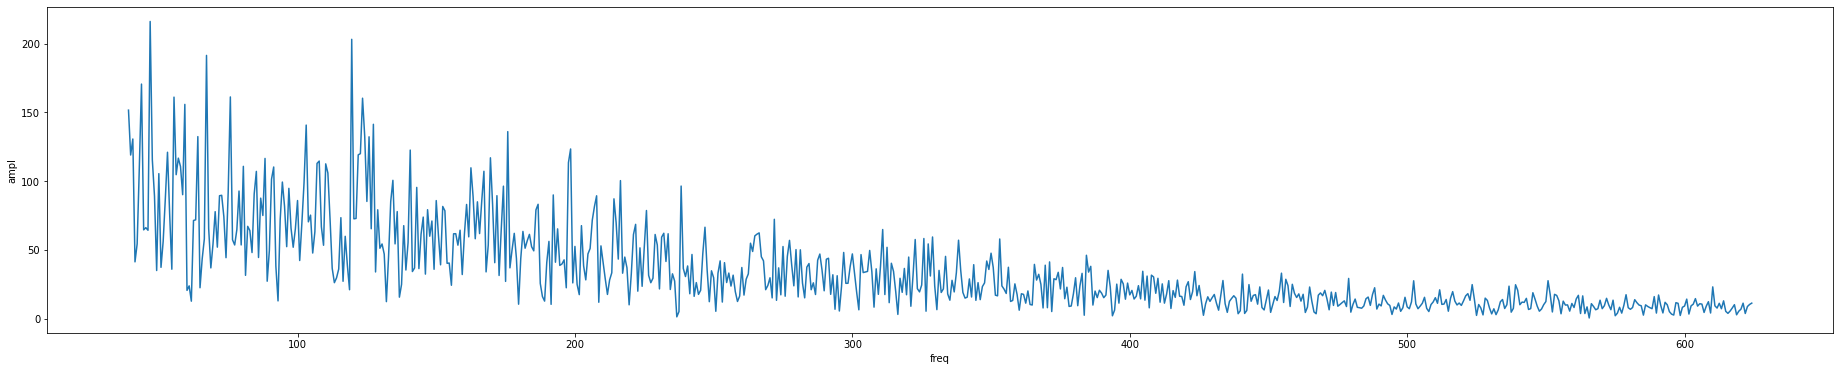

loading 35Hz12kN/Bearing1_1/120.csv
maxlevel is 11


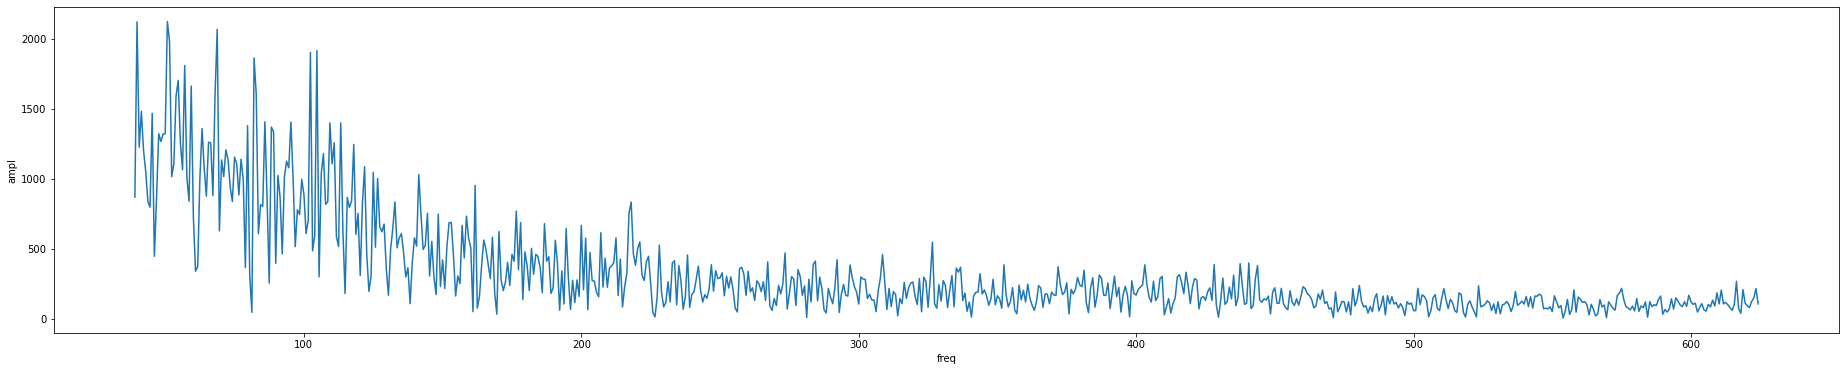

In [41]:
index = np.arange(0,1.28, 1/25600)
def denoise(filename):
    print(f"loading {filename}")
    df = pd.read_csv(filename)
    df = df.rename(columns={"Horizontal_vibration_signals":"H", "Vertical_vibration_signals":"V"})
    data = df.V
    w = pywt.Wavelet('db8')
    maxlev = pywt.dwt_max_level(len(df.V), w.dec_len)
    print(f"maxlevel is {maxlev}")
    threshold = 0.4
    coeffs = pywt.wavedec(data, 'db8', level=maxlev)
    
 
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))
    datarec = pywt.waverec(coeffs, 'db8')
    mintime = 0
    maxtime = mintime + len(data) + 1

#     plt.figure(figsize=(32,16))
#     plt.subplot(2, 1, 1) #两行1列第一个位置
#     plt.plot(index[mintime:maxtime], data[mintime:maxtime])
#     plt.xlabel('time (s)')
#     plt.ylabel('microvolts (uV)')
#     plt.title("Raw signal")
#     plt.subplot(2, 1, 2) #两行1列第二个位置
#     plt.plot(index[mintime:maxtime], datarec[mintime:maxtime-1])
#     plt.xlabel('time (s)')
#     plt.ylabel('microvolts (uV)')
#     plt.title("De-noised signal using wavelet techniques")

#     plt.tight_layout() #自动调整子图参数，使之填充整个图像区域
#     plt.show()
    return datarec

def process_emd(data):
    emd = EMD()
    imfs = emd(data)
    imf = imfs[0]
    
    envelope = sp.signal.hilbert(imf)
#     plt.figure(figsize=(32,8))
#     plt.plot(index, np.abs(envelope))
#     plt.show()
    
    r = [50, 800]
    ampl = np.fft.rfft(np.abs(envelope))[r[0]: r[1]]
    freq = np.fft.rfftfreq(len(envelope), 1/25600)[r[0]: r[1]]
    plt.figure(figsize=(32,6))
    plt.plot(freq, np.abs(ampl))
    plt.ylabel("ampl")
    plt.xlabel("freq")
    plt.show()
    
data = denoise('35Hz12kN/Bearing1_1/1.csv')
process_emd(data)

data = denoise('35Hz12kN/Bearing1_1/120.csv')
process_emd(data)